# MCMC Polynomial Fitting
- Phase Variation = 1st or 2nd order sinusoid
- Polynomial = 2nd-5th order polynomial
- Can also do ellipsoidal varations

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [1]:
'''Import Package'''

import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

from astropy import constants as const
from astropy import units

import numpy as np
import time as t
import os, sys
import csv

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import helpers
import astro_models
import make_plots
import make_plots_custom
import detec_models
import bliss

import inspect

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.time
from astropy.stats import sigma_clip
from astropy.table import Table, Column

%matplotlib inline

Error: binrms from timeavg failed to import


In [2]:
user = 'Lisa'

In [3]:
'''SETUP for Taylor'''
if user == 'Taylor':
    planet   = 'WASP-12b_old'                # Name of the planet
    channel  = 'ch1'                         # Spitzer channel
    mode     = 'Poly5_v1_shortBoxcar'        #_shortBoxcar'        # Detector model and Phase variation order
    if planet=='WASP-12b':
        if channel=='ch2':
            phoption = '4umHardCircular3_2'  # photometry option
        else:
            if 'shortBoxcar' in mode:
                phoption = '3umExactCircular2_9' # photometry option
            else:
                phoption = '3umExactCircular4_5' # photometry option
    else:
        if channel=='ch2':
            phoption = '4umHardCircular2_5'  # photometry option
        else:
            if 'shortBoxcar' in mode:
                phoption = '3umExactCircular4_3'  # photometry option
            else:
                phoption = '3umHardCircular4_5'  # photometry option
                
    compFactor = 1.
    if 'old' in planet.lower() and channel=='ch1':
        compFactor += 0.9332*0.1149
    elif 'old' in planet.lower() and channel=='ch2':
        compFactor += 0.8382*0.1196
    elif 'old' not in planet.lower() and channel=='ch1':
        compFactor += 0.8773*0.1149
    elif 'old' not in planet.lower() and channel=='ch2':
        compFactor += 0.8858*0.1196
    
    nFrames  = 64                            # number of frames per binned data point
    initializeWithOld = False                # initial with previous mcmc results
    runMCMC = True                           # whether to run MCMC or just load-in past results
    nBurnInSteps = 3e5                       # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e5                   # number of steps to use with mcmc production run
    usebestfit = False                       # used best-fit instead of most probable parameters 
    blissNBin = 8                            # number of knots to allow in each direction
    secondOrderOffset = False                # should you use the second order sinusoid terms when calculating offset
    bestfitNbin = 50                         # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
    
    if planet == 'WASP-12b':
        AOR_snip = '4801'
    else:
        if channel == 'ch2':
            AOR_snip = '4158'
        else:
            AOR_snip = '4126'
    
    # Master path
    mainpath   = '/home/taylor/Documents/Research/spitzer/'+planet+'/analysis/'
    # path where outputs are saved
    foldername = mainpath + channel +'/' + phoption + '/'
    savepath   = foldername + mode + '/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs'+AOR_snip+'.dat'
    filenamef  = channel + '_datacube_full_AORs'+AOR_snip+'.dat'
    # Path to previous mcmc results (optional)
    path_params = foldername + mode + '/ResultMCMC_'+mode+'_Params.npy'
    
    if planet == 'WASP-12b':
        if channel=='ch1':
            timeaor1 = 56638.7346502+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
            timeaor2 = 56639.234842+1/3600/24   #Taken from BMJD from 1st file of 3nd aor

            ignoreFrames = [0,1]

        else:
            timeaor1 = 56641.9990393+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
            timeaor2 = 56642.4991651+1/3600/24  #Taken from BMJD from 1st file of 3nd aor

            ignoreFrames = [0,1]
        breaks = np.array([timeaor1, timeaor2])
    else:
        if channel=='ch1':
            timeaor1 = 55518.1649117+1/3600/24  #Taken from BMJD from 1st file of 2nd aor

            ignoreFrames = [0]

        else:
            timeaor1 = 55542.196255+1/3600/24  #Taken from BMJD from 1st file of 2nd aor

            ignoreFrames = [0]
        breaks = np.array([timeaor1])

    # non-zero if you cut initial data set (DANGER)
    cut = 0

In [4]:
if user=='Taylor':
    
    # parameter you do not wish to fit
    dparams = ['per','ecosw','esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.t0    = 56176.168258                    # BMJD time
    p0_obj.per   = 1.0914203                       # in days
    p0_obj.rp    = 0.11785                         # planetary radius (in stellar radii) 
    p0_obj.a     = 3.039                           # orbital semi-major axis (in stellar radii)
    p0_obj.inc   = 83.37                           # in degrees: 90 = edge-on                
    p0_obj.ecosw = 0                               # ecc and w # np.cos only takes rad
    p0_obj.esinw = 0                               # ecc and w # np.sin only takes rad
    p0_obj.q1    = 0.1
    p0_obj.q2    = 0.1
    p0_obj.fp    = 0.004                           # eclipse depth in units of stellar flux
    p0_obj.Tstar = 6300
    p0_obj.TstarUncert = 150
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    p0_obj.r2    = p0_obj.rp
    p0_obj.r2off = 0.0
    
    p0_obj.sigF = 0.001
    
    p0_obj.mode = mode
    
    #lnprior_custom = 'none'
    
    priors = [56176.168258, 3.039, 83.37]
    errs = [0.00007765,0.0335,0.68]
    
    if 'ellipse' in mode.lower():
        def lnprior_custom_taylor(t0, a, i, rp, r2, r2off, priors, errs):
            if r2 > 0 and r2 < 1 and -45 <= r2off < 45:
                t0_prior = -0.5*(((t0 - priors[0])/errs[0])**2.0)
                a_prior = -0.5*(((a - priors[1])/errs[1])**2.0)
                i_prior = -0.5*(((i - priors[2])/errs[2])**2.0)
                return t0_prior+a_prior+i_prior
            else:
                return -np.inf
        
        if 'offset' in mode:
            lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], p0[np.where(p0_labels=='rp')[0][0]], p0[np.where(p0_labels=='r2')[0][0]], p0[np.where(p0_labels=='r2off')[0][0]], priors, errs)
        else:
            lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], p0[np.where(p0_labels=='rp')[0][0]], p0[np.where(p0_labels=='r2')[0][0]], 0, priors, errs)
            
    else:
        def lnprior_custom_taylor(t0, a, i, priors, errs):
            t0_prior = -0.5*(((t0 - priors[0])/errs[0])**2.0)
            a_prior = -0.5*(((a - priors[1])/errs[1])**2.0)
            i_prior = -0.5*(((i - priors[2])/errs[2])**2.0)
            return t0_prior+a_prior+i_prior
        
        lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], priors, errs)

In [5]:
# A cell that can be used to calculate the photon noise limit
# flux = np.loadtxt(foldername+filename, usecols=[0], skiprows=1)     # mJr/str
# from astropy.io import fits
# #hdu_list = fits.open('/home/taylor/Documents/Research/spitzer/WASP-12b_old/data/ch2/r41587200/ch2/bcd/SPITZER_I2_41587200_0001_0000_2_bcd.fits')
# #hdu_list = fits.open('/home/taylor/Documents/Research/spitzer/WASP-12b_old/data/ch1/r41260032/ch1/bcd/SPITZER_I1_41260032_0003_0000_2_bcd.fits')
# hdu_list = fits.open('/home/taylor/Documents/Research/spitzer/WASP-12b/data/ch2/r48015872/ch2/bcd/SPITZER_I2_48015872_0330_0000_2_bcd.fits')
# #hdu_list = fits.open('/home/taylor/Documents/Research/spitzer/WASP-12b/data/ch1/r48014848/ch1/bcd/SPITZER_I1_48014848_0003_0000_2_bcd.fits')
# #flux *= hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
# flux *= hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
# 
# 1/np.sqrt(np.median(flux))/np.sqrt(64-len(ignoreFrames))*1e6

In [6]:
if user == 'Lisa':
    planet   = 'XO-3b'                         # Name of the planet
    channel  = 'ch1'                           # Spitzer channel
    mode     = 'PLD1_3x3_v1_eccent'            # Detector model and Phase variation order *do not use anything with PLD*
    #mode     = 'test_Poly2_v1_eccent_psfw'
    year     = '2013'
    
    if 'pld'in mode.lower():
        if '3x3' in mode.lower():
            if channel == 'ch1':
                phoption = '3um_PLD_3x3'
            else:
                phoption = '4um_PLD_3x3'
        elif '5x5' in mode.lower():
            if channel == 'ch1':
                phoption = '3um_PLD_5x5'
            else:
                phoption = '4um_PLD_5x5'
        else: 
            print('Error, only PLD 3x3 and 5x5 is implemented!')
    
    else:
        if channel == 'ch1':
            phoption = '3umFixedCenterCircular6_25'# photometry option
        else:
            phoption = '4umFixedCenterCircular3_75'# photometry option
    
    nFrames  = 64                              # number of frames per binned data point
    initializeWithOld = False                  # initial with previous mcmc results
    runMCMC = True                             # whether to run MCMC or just load-in past results
    nBurnInSteps = 3e2                         # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e2                     # number of steps to use with mcmc production run
    usebestfit = True                          # used best-fit instead of most probable parameters 
    blissNBin = 10                             # number of knots to allow in each direction
    secondOrderOffset = False                  # should you use the second order sinusoid terms when calculating offset
    bestfitNbin = 50                           # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
    
    # Master path
    mainpath   = '/volumes/Seagate Expansion Drive/Research/XO-3b/'
    # path where outputs are saved
    foldername = mainpath + channel +'/Analysis_'+year+'/' + phoption + '/' 
    # create directory for your mode
    savepath    = foldername + mode + '/'
    if not os.path.exists(savepath): os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs464.dat'
    filenamef  = channel + '_datacube_full_AORs464.dat'
    # Path to previous mcmc results (optional)
    #path_params = foldername + 'Poly2_v1_eccent_psfw_trim/ResultMCMC_Poly2_v1_eccent_psfw_trim_Params.npy'
    path_params = foldername + 'Poly2_v1_eccent_psfw/ResultMCMC_Poly2_v1_eccent_psfw_Params.npy'

    # I removed the first 12 datacubes (calibration data)
    cut = 11
    # breaks from on AOR to another (luckily same for both channels)
    ind_AOR = [11,343,676,1009,1333,1675,2008,2341,2398]
    # frames to be ignored according to the frames systematics
    if channel == 'ch1':
        ignoreFrames = [0,1,2]
    elif channel == 'ch2':
        ignoreFrames = [0]

In [7]:
if user=='Lisa':
    # parameter you do not wish to fit
    dparams = ['per', 'a', 'inc', 'ecosw', 'esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 
    
    # Some definition for XO-3b
    r_star            = 1.377                    # for XO-3 in solar radius
    r_sol2jup         = 0.10049                  # jupiter radius in solar radius
    r_sol2AU          = 214.93946938             # AU radius in solar radius

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.per  = 3.1915239                       # in days
    p0_obj.rp   = 0.125/r_star                    # planetary radius (in solar radius)/stellar radius (solar radius) 
    p0_obj.a    = 0.0454*r_sol2AU/r_star          # 
    p0_obj.inc  = 84.20                           # 90 = edge-on                
    p0_obj.ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
    p0_obj.esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
    p0_obj.q1   = 0.001
    p0_obj.q2   = 0.001
    p0_obj.fp   = 0.001                           # eclipse depth in units of stellar flux
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    p0_obj.Tstar = 6300
    p0_obj.TstarUncert = 150
    
    if channel == 'ch1':
        peritime    = 56395.57202659136
        p0_obj.t0   = 56396.20277778              # BMJD time
        
    if channel == 'ch2':
        peritime    = 56417.90827381378
        p0_obj.t0   = 56418.540                   # BMJD time
    
    p0_obj.r2   = p0_obj.rp 
    p0_obj.mode = mode

    # define priors
    if channel == 'ch1':
        if year=='2013':
            def lnprior_custom_Lisa(t0):
                #lgpri_per = -0.5*(((per - 3.1915325)/0.0000006)**2.0)
                #lgpri_a = -0.5*(((a - 7.07)/0.31)**2.0)
                #lgpri_i = -0.5*(((inc - 84.11)/0.16)**2.0)
                #lgpri_ecosw = -0.5*(((ecosw - 0.27005)/0.00026)**2.0)
                #lgpri_esinw = -0.5*(((esinw +  0.0612)/0.0083)**2.0)
                if ((t0 < 56396.25) and (t0 >56396.15)):
                    return 0.0 #+ lgpri_a + lgpri_i + lgpri_ecosw + lgpri_esinw + lgpri_per
                return -np.inf
            
            lnprior_custom = lambda p0: lnprior_custom_Lisa(p0[np.where(p0_labels=='t0')[0][0]])
    
    if channel == 'ch2':
        if year == '2013':
            def lnprior_custom(t0):
                #lgpri_per = -0.5*(((per - 3.1915325)/0.0000006)**2.0)
                #lgpri_a = -0.5*(((a - 7.07)/0.31)**2.0)
                #lgpri_i = -0.5*(((inc - 84.11)/0.16)**2.0)
                #lgpri_ecosw = -0.5*(((ecosw - 0.27005)/0.00026)**2.0)
                #lgpri_esinw = -0.5*(((esinw +  0.0612)/0.0083)**2.0)
                if (56396.15 < t0 < 56396.25):
                    return 0.0 #+ lgpri_a + lgpri_i + lgpri_ecosw + lgpri_esinw + lgpri_per
                return -np.inf
                      
            

# Everything below is now automated

In [8]:
signalfunc = detec_models.signal

if 'poly' in mode.lower():
    detecfunc = detec_models.detec_model_poly
elif 'bliss' in mode.lower():
    detecfunc = detec_models.detec_model_bliss
elif 'pld' in mode.lower():
    detecfunc = detec_models.detec_model_PLD
else:
    raise NotImplementedError('Only polynomial and BLISS models are currently implemented! \nmode=\''+mode+'\' does not include \'poly\', \'Poly\', \'bliss\', or \'BLISS\'.')

In [9]:
# labels for all the possible fit parameters
p0_names = np.array(['t0', 'per', 'rp', 'a', 'inc', 'ecosw', 'esinw', 'q1', 'q2', 'fp', 
                     'A', 'B', 'C', 'D', 'r2', 'r2off', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                     'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17',
                     'c18', 'c19', 'c20', 'c21', 'd1', 'd2', 'd3', 's1', 's2', 'm1','p1_1', 
                     'p2_1', 'p3_1', 'p4_1', 'p5_1', 'p6_1', 'p7_1', 'p8_1', 'p9_1', 'p10_1', 
                     'p11_1', 'p12_1', 'p13_1', 'p14_1', 'p15_1', 'p16_1', 'p17_1', 'p18_1', 
                     'p19_1', 'p20_1', 'p21_1', 'p22_1', 'p23_1', 'p24_1', 'p25_1', 'p1_2', 
                     'p2_2', 'p3_2', 'p4_2', 'p5_2', 'p6_2', 'p7_2', 'p8_2', 'p9_2', 'p10_2', 
                     'p11_2', 'p12_2', 'p13_2', 'p14_2', 'p15_2', 'p16_2', 'p17_2', 'p18_2', 
                     'p19_2', 'p20_2', 'p21_2', 'p22_2', 'p23_2', 'p24_2', 'p25_2',  'sigF'])

# fancy labels for plot purposed  for all possible fit parameters
p0_fancyNames = np.array([r'$t_0$', r'$P_{\rm orb}$', r'$R_p/R_*$', r'$a/R_*$', r'$i$', r'$e \cos(\omega)$',
                          r'$e \sin(\omega)$', r'$q_1$', r'$q_2$', r'$f_p$', r'$A$', r'$B$',
                          r'$C$', r'$D$', r'$R_{p,2}/R_*$', r'$R_{p,2}/R_*$ Offset', r'$C_1$', r'$C_2$', r'$C_3$',
                          r'$C_4$', r'$C_5$', r'$C_6$', r'$C_7$', r'$C_8$', r'$C_9$',
                          r'$C_{10}$', r'$C_{11}$', r'$C_{12}$', r'$C_{13}$', r'$C_{14}$',
                          r'$C_{15}$', r'$C_{16}$', r'$C_{17}$', r'$C_{18}$', r'$C_{19}$',
                          r'$C_{20}$', r'$C_{21}$',r'$D_1$', r'$D_2$', r'$D_3$', r'$S_1$', r'$S_2$', r'$M_1$', 
                          r'$p_{1-1}$', r'$p_{2-1}$', r'$p_{3-1}$', r'$p_{4-1}$', r'$p_{5-1}$', r'$p_{6-1}$', 
                          r'$p_{7-1}$', r'$p_{8-1}$', r'$p_{9-1}$', r'$p_{10-1}$', r'$p_{11-1}$', r'$p_{12-1}$', 
                          r'$p_{13-1}$', r'$p_{14-1}$', r'$p_{15-1}$', r'$p_{16-1}$', r'$p_{17-1}$', r'$p_{18-1}$', 
                          r'$p_{19-1}$', r'$p_{20-1}$', r'$p_{21-1}$', r'$p_{22-1}$', r'$p_{23-1}$', r'$p_{24-1}$', 
                          r'$p_{25-1}$', r'$p_{1-2}$', r'$p_{2-2}$', r'$p_{3-2}$', r'$p_{4-2}$', r'$p_{5-2}$', 
                          r'$p_{6-2}$', r'$p_{7-2}$', r'$p_{8-2}$', r'$p_{9-2}$', r'$p_{10-2}$', r'$p_{11-2}$', 
                          r'$p_{12-2}$', r'$p_{13-2}$', r'$p_{14-2}$', r'$p_{15-2}$', r'$p_{16-2}$', r'$p_{17-2}$', 
                          r'$p_{18-2}$', r'$p_{19-2}$', r'$p_{20-2}$', r'$p_{21-2}$', r'$p_{22-2}$', r'$p_{23-2}$', 
                          r'$p_{24-2}$', r'$p_{25-2}$', r'$\sigma_F$'])

In [10]:
# loading full data set for BIC calculation afterwards

if 'pld' in mode.lower():
    # get data from photometry
    data = helpers.get_full_data(foldername+filenamef, mode)
    # Keeping P_full for chi2 on unbinned data calculation
    P_full = data[0]
    # transposing
    P_full = P_full.T
    P_full = P_full/np.median(np.sum(P_full, axis=0))
    # calculate the flux by summing over P
    flux_full = np.sum(P_full, axis=0)
    # sigma clip the data
    flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full = helpers.clip_full_data(flux_full, [], *data[1:], nFrames, cut, ignoreFrames)
    mid_x_full, mid_y_full = np.nanmean(xdata_full), np.nanmean(ydata_full)
    # get Pnorm
    Pnorm_full = P_full/flux_full
    
else:
    # get data from photometry
    data_full = helpers.get_full_data(foldername+filenamef, mode)

    # sigma clip the data
    flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full = helpers.clip_full_data(*data_full, nFrames, cut, ignoreFrames)
    mid_x_full, mid_y_full = np.nanmean(xdata_full), np.nanmean(ydata_full)

ValueError: operands could not be broadcast together with shapes (9,153600) (145060,) 

In [ ]:
P_full.shape

In [ ]:
flux_full.shape

In [11]:
cut*64

704

In [14]:
2400*3+145060+704

152964

In [ ]:
if 'pld' in mode.lower():
    # Get Data
    data = helpers.get_data(foldername+filename, mode)    
    # Sort data
    P_0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.time_sort_data(*data)
    # Trim AOR
    P, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.time_sort_data(*data, cut=cut)
    # pre-calculation
    mid_x, mid_y = np.mean(xdata), np.mean(ydata)
    # transposing Pixel intensities and normalizing
    P_0, P = P_0.T, P.T
    P_0, P = P_0/np.median(np.sum(P_0, axis=0)), P/np.median(np.sum(P_0, axis=0))
    # calculate flux by summing P
    flux0 = np.sum(P_0, axis=0)
    flux  = np.sum(P, axis=0)
    # get P-hats from Deming et al. 2015
    Pnorm_0,Pnorm = P_0/flux0, P/flux
    
else:
    # Get Data
    data = helpers.get_data(foldername+filename, mode)
    # Sort data
    flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.time_sort_data(*data)
    # Trim AOR
    flux, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.time_sort_data(*data, cut=cut)
    # pre-calculation
    mid_x, mid_y = np.mean(xdata), np.mean(ydata)

# get AOR delimitation (TO BE REMOVED)
if user=='Taylor':
    # make photometry plots
    make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                    time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath)
    
if user=='Lisa':
    breaks = np.empty(len(ind_AOR))
    for i in range(len(ind_AOR)):
        breaks[i] = time0[ind_AOR[i]]
    # plot raw data
    make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                    time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath, peritime)

In [ ]:
# declare where the heaviside break occurs
if 'hside' in mode.lower():
    if user == 'Taylor':
        p0_obj.s2 = timeaor1
        dparams = np.append(dparams, ['s2'])
    elif user == 'Lisa':
        p0_obj.s2 = breaks[2]
        dparams = np.append(dparams, ['s2'])

In [ ]:
# redefining the zero centroid position
if 'bliss' not in mode.lower():
    xdata -= mid_x
    ydata -= mid_y
    xdata_full -= mid_x_full
    ydata_full -= mid_y_full

In [ ]:
# True if user wants details about the lambda functions created
debug = False

# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams, mode)  

# if you want to use the best fit params from a previous MCMC run
if initializeWithOld:
    Table_par = np.load(path_params)                  # table of best-fit params from prev. run
    index     = np.in1d(p0_names, dparams)            # get the index list of params to be fitted
    nparams   = p0_names[np.where(index==False)[0]]   # get the name list of params to be fitted
    for name in nparams:
        cmd = 'p0_obj.' + name + ' = ' + 'Table_par[\'' + name + '\'][0]'
        try:
            exec(cmd)
        except Exception as e:
            print("type error: " + str(e))            # catch errors if you use values from fun with less params

In [ ]:
debug = False
# get p0
obj = p0_obj
p0, p0_labels, p0_fancyLabels = helpers.get_p0(p0_names, p0_fancyNames, dparams, p0_obj)
#p0_signal  = p0
#if 'sigF' in p0_labels:
#    p0_signal = p0_signal[:-1]

# make lambda function
signalfunc = helpers.make_lambdafunc(signalfunc, dparams, p0_obj, debug=debug)
if debug:
    print()

# making lambda function for phasecurve and detector
astrofunc = helpers.make_lambdafunc(astro_models.ideal_lightcurve, dparams, p0_obj, debug=debug)
if debug:
    print()

detecfunc = helpers.make_lambdafunc(detecfunc, dparams, p0_obj, debug=debug)
if debug:
    print()
    
psfwifunc = helpers.make_lambdafunc(detec_models.detec_model_PSFW, dparams, p0_obj, debug=debug)
if debug:
    print()
    
hsidefunc = helpers.make_lambdafunc(detec_models.hside, dparams, p0_obj, debug=debug)
if debug:
    print()

# make a lnprior lambda function
lnpriorfunc = helpers.make_lambdafunc(helpers.lnprior, dparams, obj=p0_obj, debug=debug)

# detemining which params in p0 is part of ideal_lightcurve, detec, psfw
p0_astro  = inspect.getargspec(astro_models.ideal_lightcurve).args[1:]
p0_asval, p0_astro, p0_astroFancy  = helpers.get_p0(p0_astro, p0_fancyNames, dparams,p0_obj)

if 'bliss' not in mode.lower():
    p0_detec  = inspect.getargspec(detecfunc).args[1:]
    p0_deval, p0_detec, p0_detecFancy  = helpers.get_p0(p0_detec, p0_fancyNames, dparams,p0_obj)
else:
    if 'sigF' in dparams:
        p0_detec = []
        p0_detecFancy = []
        p0_deval = p0_obj.sigF
    else:
        p0_detec = p0_labels[-1]
        p0_detecFancy = p0_fancyLabels[-1]
        p0_deval = p0[-1]

p0_psfwi  = inspect.getargspec(detec_models.detec_model_PSFW).args[1:]
p0_psval, p0_psfwi, p0_psfwiFancy  = helpers.get_p0(p0_psfwi, p0_fancyNames, dparams,p0_obj)

p0_hside  = inspect.getargspec(detec_models.hside).args[1:]
p0_hsval, p0_hside, p0_hsideFancy  = helpers.get_p0(p0_hside, p0_fancyNames, dparams,p0_obj)

## Getting initial detector params guesses

In [ ]:
# initial astro model
astro_guess = astrofunc(time, *p0_asval)
resid       = flux/astro_guess


if 'bliss' in mode.lower():
    make_plots.plot_centroids(xdata0, ydata0, xdata, ydata, savepath)
    
    signal_inputs = bliss.precompute(flux, time, xdata, ydata, psfxw, psfyw, mode,
                                     astro_guess, blissNBin, savepath)
elif 'pld' in mode.lower():
    signal_inputs = (flux, time, Pnorm, mode)
    detec_inputs  = (Pnorm, mode)
elif 'poly' in mode.lower():# and 'psfw' in mode.lower():
    signal_inputs = (flux, time, xdata, ydata, psfxw, psfyw, mode)
    detec_inputs = (xdata, ydata, mode)


'''Good for Poly'''
if not initializeWithOld and 'poly' in mode.lower():
    # 1) get initial guess for detec model
    p0_deval, _ = scipy.optimize.curve_fit(detecfunc, detec_inputs, resid, p0_deval)

    # replace p0 with new detector coefficient values
    for i in range(len(p0_detec)):
        index = np.where(np.in1d(p0_labels,p0_detec[i]))
        p0[index] = p0_deval[i]

    # 2) get initial guess for psfw model
    if 'psfw' in mode.lower():
        p0_psval, _ = scipy.optimize.curve_fit(psfwifunc, (psfxw, psfyw), resid, p0_psval)

        for i in range(len(p0_psfwi)):
            index = np.where(np.in1d(p0_labels,p0_psfwi[i]))
            p0[index] = p0_psval[i]

    # 3) get initial guess for hside model
    if 'hside' in mode.lower():
        p0_hsval, _ = scipy.optimize.curve_fit(hsidefunc, time, resid, p0_hsval)

        for i in range(len(p0_hside)):
            index = np.where(np.in1d(p0_labels,p0_hside[i]))
            p0[index] = p0_hsval[i]
            
'''Good for PLD'''
if not initializeWithOld and 'pld' in mode.lower():
    p0_deval, _ = scipy.optimize.curve_fit(detecfunc, detec_inputs, resid, p0_deval)

    # replace p0 with new detector coefficient values
    for i in range(len(p0_detec)):
        index = np.where(np.in1d(p0_labels,p0_detec[i]))
        p0[index] = p0_deval[i]
    
# initial guess
signal_guess = signalfunc(signal_inputs, *p0)
#includes psfw and/or hside functions if they're being fit
detec_full_guess = signal_guess/astro_guess

# plot detector initial guess
make_plots.plot_init_guess(time, flux, astro_guess, detec_full_guess, savepath, mode)

## Running MCMC

In [ ]:
ndim, nwalkers = len(p0), 300

if runMCMC:
    # get scattered starting point in parameter space 
    # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
    pos0 = [p0*(1+1e-5*np.random.randn(ndim))+1e-5*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]

    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    #sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, a = 2,
                                    args=(signalfunc, lnpriorfunc, 
                                          signal_inputs, checkPhasePhis, lnprior_custom))

    #if lnpriorfunc(*p0, mode, checkPhasePhis) != 0.0 or (lnprior_custom != 'none' and lnprior_custom(p0) != 0.0):
    #    print('Error: Initial values fail the lnprior and the following MCMC will not work!')
    
    
    #First burn-in:
    tic = t.time()
    print('Running burn-in')
    pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps/nwalkers))
    print("Mean burn-in acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
    
    
    #Second burn-in
    #Continue from best spot from last time, and do quick burn-in to get walkers spread out
    tic = t.time()
    print('Running second burn-in')
    pos2 = pos1[np.argmax(prob)]
    # slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(ndim))+1e-6*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]
    pos2, prob, state = sampler.run_mcmc(pos2, np.rint(nBurnInSteps/nwalkers))
    print('Mean burn-in acceptance fraction: {0:.3f}'
                    .format(np.median(sampler.acceptance_fraction)))
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
    
    
    #Run production
    #Run that will be saved
    tic = t.time()
    # Continue from last positions and run production
    print('Running production')
    pos3, prob, state = sampler.run_mcmc(pos2, np.rint(nProductionSteps/nwalkers))
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
    
    
    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, sampler.chain)
    np.save(pathposit, pos3)
    np.save(pathlnpro, prob)
    
    chain = sampler.chain
    
else:
    
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    chain = np.load(pathchain)
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    if os.path.exists(pathlnpro):
        lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

## Remove Outliers Walkers
mostly outliers in time of transit

In [ ]:
if user == 'Lisa':
    # copy to not compromise
    t0walkers = np.copy(samples[:,0])
    # get index for params group with t0 out of range
    if channel == 'ch1':
        index = np.where(np.logical_or(t0walkers<=56396.15, t0walkers>=56396.25))
    elif channel == 'ch2':
        index = np.where(np.logical_or(t0walkers<=56418.4, t0walkers>=56418.6))
    print('Number of params group deleted:', len(index[0]))
    # replace samples with samples without bad group
    samplescopy = np.copy(samples)
    samples  = np.delete(samplescopy, index[0], axis=0)
    # plot histogram to see if you have been successful 
    n, bins, patches = plt.hist(samples[:,0], 50, density=True, facecolor='g', alpha=0.75)

## Fold inclination back around since i>90 is meaningless

In [ ]:
if 'inc' in p0_labels:
    pos_inc = np.where(p0_labels == 'inc')[0][0]
    samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc] = 180 - samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc]

In [11]:
#print the results

(MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))
p0_mcmc = np.median(samples, axis=0)

# taking max lnprob params instead of median bc degeneracy
if usebestfit == True: 
    if runMCMC == True:
        maxk, maxiter = np.unravel_index((sampler.lnprobability).argmax(), (sampler.lnprobability).shape)
        p0_mcmc = sampler.chain[maxk, maxiter,:]
    else:
        maxk, maxiter = np.unravel_index((lnprobability).argmax(), (lnprobability).shape)
        p0_mcmc = chain[maxk, maxiter,:]
    for i in range(len(p0_mcmc)):
        MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

# adjust fp, sigF, rp, r2 for dilution due to nearby companion
if user == 'Taylor':
    if np.any(p0_labels == 'fp'):
        for i in range(3):
            MCMC_Results[np.where(p0_labels == 'fp')[0][0]][i] *= compFactor
    if np.any(p0_labels == 'sigF'):
        for i in range(3):
            MCMC_Results[np.where(p0_labels == 'sigF')[0][0]][i] *= compFactor
    if np.any(p0_labels == 'rp'):
        for i in range(3):
            MCMC_Results[np.where(p0_labels == 'rp')[0][0]][i] *= np.sqrt(compFactor)
    if np.any(p0_labels == 'r2'):
        for i in range(3):
            MCMC_Results[np.where(p0_labels == 'r2')[0][0]][i] *= np.sqrt(compFactor)

NameError: name 'samples' is not defined

In [12]:
# printing output from MCMC
out = "MCMC result:\n\n"
for i in range(len(p0)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])

'''# getting and printing the phase offset
As = samples[:,np.where(p0_labels == 'A')[0][0]][:,np.newaxis]
Bs = samples[:,np.where(p0_labels == 'B')[0][0]][:,np.newaxis]
phis = np.linspace(-np.pi,np.pi,1000)
offsets = []
stepSizeOffsets = int(1e4)
if ('A' in p0_labels)  and ('B' in p0_labels) and (('C' not in p0_labels and 'D' not in p0_labels) or not secondOrderOffset):
    for i in range(int(len(As)/stepSizeOffsets)):
        offsets.extend(-phis[np.argmax(1 + As[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*(np.cos(phis)-1) + Bs[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*np.sin(phis),axis=1)]*180/np.pi)
    if len(As)%stepSizeOffsets != 0:
        offsets.extend(-phis[np.argmax(1 + As[-len(As)%stepSizeOffsets:]*(np.cos(phis)-1) + Bs[-len(As)%stepSizeOffsets:]*np.sin(phis),axis=1)]*180/np.pi)
    offset = np.percentile(np.array(offsets), [16, 50, 84])[[1,2,0]]
    offset[1] -= offset[0]
    offset[2] = offset[0]-offset[2]
    out += '{:>8} = {:>16}  +{:>16}  -{:>16} degrees east\n'.format('Offset', offset[0], offset[1], offset[2])
elif ('A' in p0_labels)  and ('B' in p0_labels) and ('C' in p0_labels) and ('D' in p0_labels):
    Cs = samples[:,np.where(p0_labels == 'C')[0][0]][:,np.newaxis]
    Ds = samples[:,np.where(p0_labels == 'D')[0][0]][:,np.newaxis]
    for i in range(int(len(As)/stepSizeOffsets)):
        offsets.extend(-phis[np.argmax(1 + As[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*(np.cos(phis)-1) + Bs[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*np.sin(phis) + Cs[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*(np.cos(2*phis)-1) + Ds[i*stepSizeOffsets:(i+1)*stepSizeOffsets]*np.sin(2*phis),axis=1)]*180/np.pi)
    if len(As)%stepSizeOffsets != 0:
        offsets.extend(-phis[np.argmax(1 + As[-len(As)%stepSizeOffsets:]*(np.cos(phis)-1) + Bs[-len(As)%stepSizeOffsets:]*np.sin(phis),axis=1)]*180/np.pi)
    offset = np.percentile(np.array(offsets), [16, 50, 84])[[1,2,0]]
    offset[1] -= offset[0]
    offset[2] = offset[0]-offset[2]
    out += '{:>8} = {:>16}  +{:>16}  -{:>16} degrees east\n'.format('Offset', offsets[0], offsets[1], offsets[2])
    
# print the R2/Rp ratio
if ('ellipse' in mode.lower()) and ('rp' in p0_labels) and ('r2' in p0_labels):
    out += '{:>8} = {:>16}\n'.format('R2/Rp', p0_mcmc[np.where(p0_labels == 'r2')[0][0]]/p0_mcmc[np.where(p0_labels == 'rp')[0][0]])

# adjusting for dilution
if 'compFactor' in locals():
    if channel == 'ch1':
        wav = 3.6*1e-6
    elif channel == 'ch2':
        wav = 4.5*1e-6
    if 'fp' in p0_labels:
        fp_MCMC = samples[:,np.where(p0_labels == 'fp')[0][0]]*compFactor
    #     fp_MCMC = np.random.normal(fp_MCMC, MCMC_Results[np.where(p0_labels == 'fp')[0][0]][1], int(nProductionSteps))
    else:
        fp_MCMC = p0_obj.fp
    if 'rp' in p0_labels:
        rp_MCMC = samples[:,np.where(p0_labels == 'rp')[0][0]]*np.sqrt(compFactor)
    #     rp_MCMC = np.random.normal(rp_MCMC, MCMC_Results[np.where(p0_labels == 'rp')[0][0]][1], int(nProductionSteps))
    else:
        rp_MCMC = p0_obj.rp
    
# calculate Tday Tnight
if 'eccent' not in mode:
    Tstars = np.random.normal(p0_obj.Tstar, p0_obj.TstarUncert, int(nProductionSteps))
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*Tstars))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*Tstars))-1)/(fp_MCMC*(1-2*As[:,0])/rp_MCMC**2)))**-1

    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format('T Day: ', np.median(tday), np.percentile(tday, 84)-np.median(tday), np.median(tday)-np.percentile(tday, 16))
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format('T Night: ', np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16))
'''
print(out)
with open(savepath+'MCMC_RESULTS_'+mode+'.txt','w') as file:
    file.write(out) 

NameError: name 'p0' is not defined

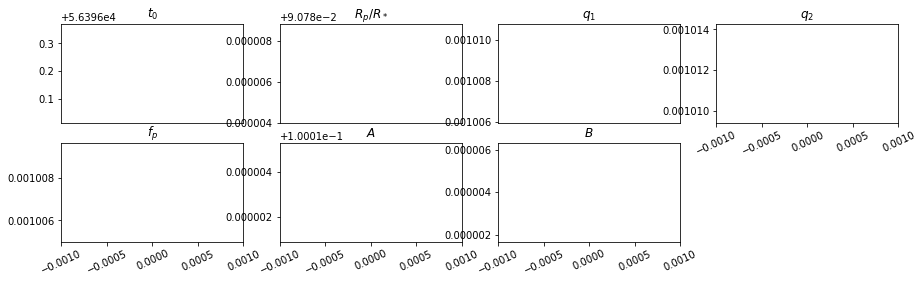

In [23]:
ind_a = len(p0_astro) # index where the astro params end
labels = p0_fancyLabels[:ind_a]

fname = savepath+'MCMC_'+mode+'_astroWalkers.pdf'
helpers.walk_style(ind_a, nwalkers, chain, 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

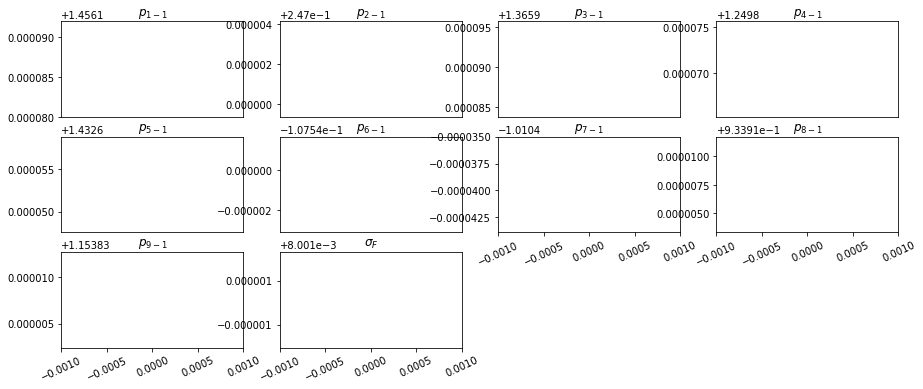

In [24]:
if 'bliss' not in mode.lower() or 'sigF' not in dparams:
    labels = p0_fancyLabels[ind_a:]
    fname = savepath+'MCMC_'+mode+'_detecWalkers.pdf'
    helpers.walk_style(len(p0)-ind_a, nwalkers, chain[:,:,ind_a:], 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

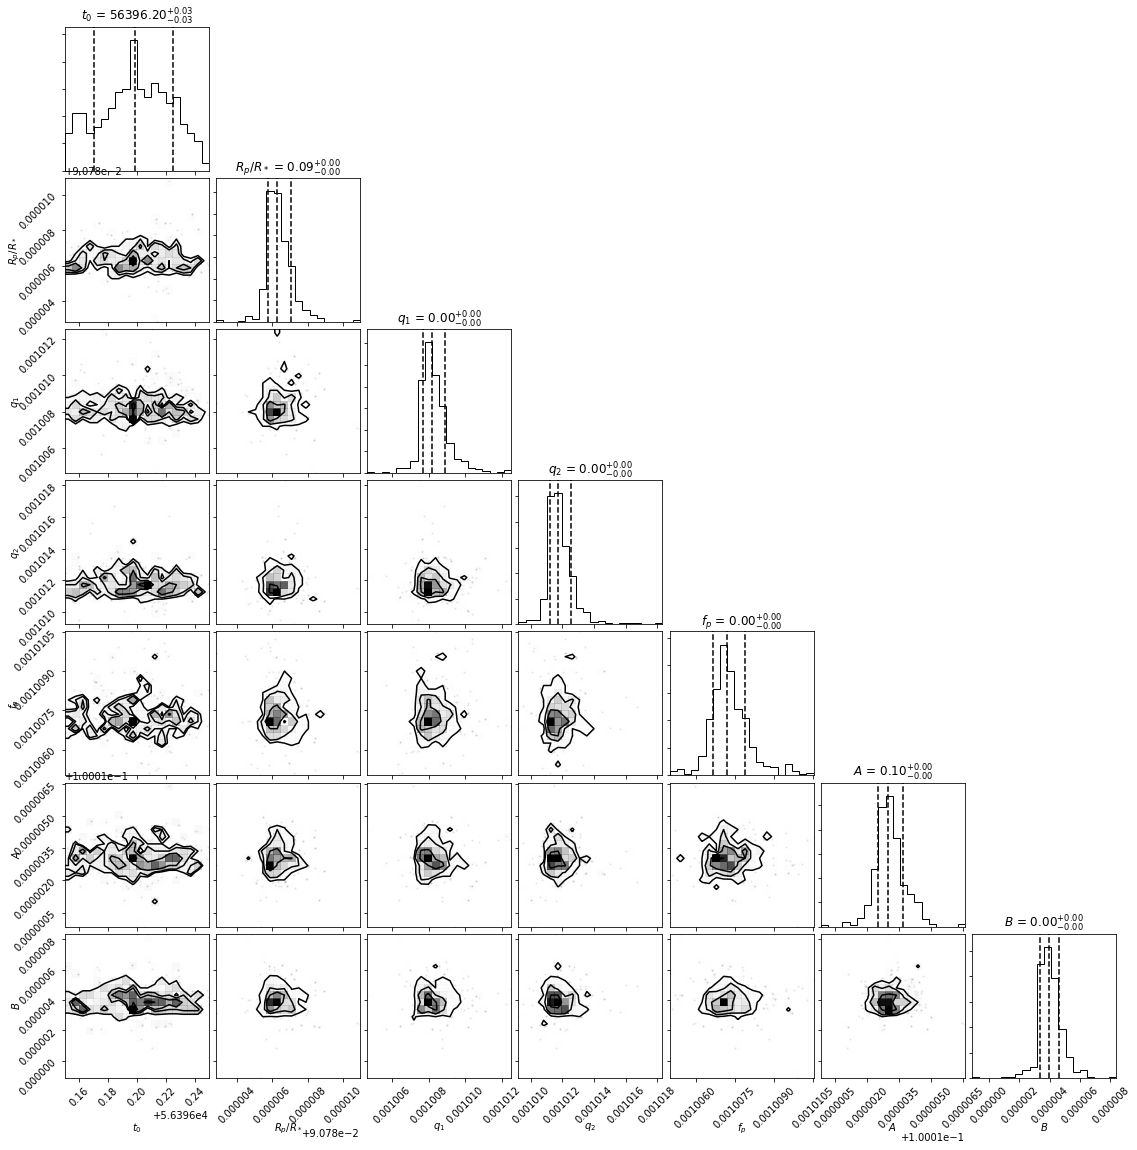

In [25]:
#save us some time when not running MCMC since this plot takes forever to make....
if runMCMC:
    fig = corner.corner(samples[:,:ind_a], labels=p0_fancyLabels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        plot_datapoints=True, title_kwargs={"fontsize": 12})
    plotname = savepath + 'MCMC_'+mode+'_corner.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    
#     fig = corner.corner(samples, labels=p0_fancyLabels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
#                         plot_datapoints=True, title_kwargs={"fontsize": 12})
#     plotname = savepath + 'MCMC_'+mode+'_corner_complete.pdf'
#     fig.savefig(plotname, bbox_inches='tight')

In [26]:
if 'ecosw' in p0_labels and 'esinw' in p0_labels:
    '''Eccentricity and Longitude of Periastron Coefficient'''
    
    ind1 = np.where(p0_labels == 'ecosw')[0][0]
    ind2 = np.where(p0_labels == 'esinw')[0][0]
    e_chain = np.sqrt(samples[:,ind1]**2 + samples[:,ind2]**2)
    w_chain = np.arctan2(samples[:,ind2], samples[:,ind1]) #np.arctan(samples[:,ind2]/samples[:,ind1])
    binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
    binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
    axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
    axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
    axes[1,0].set_title('$e$', fontsize=12)
    axes[1,1].set_title('$\omega$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_ecc-omega.pdf'
    fig.savefig(plotname, bbox_inches='tight')

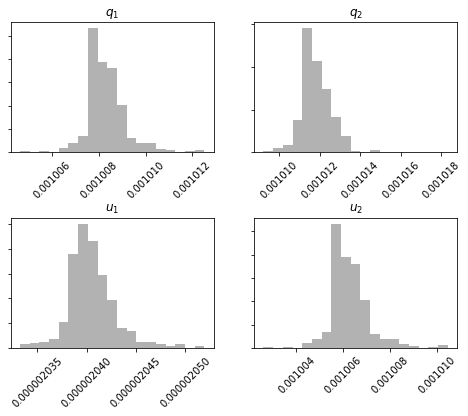

In [27]:
if 'q1' in p0_labels and 'q2' in p0_labels:
    '''Stellar Limb Darkening Parameters'''
    
    ind1 = np.where(p0_labels == 'q1')[0][0]
    ind2 = np.where(p0_labels == 'q2')[0][0]
    u1_chain = 2*np.sqrt(samples[:,ind1]**2)*samples[:,ind2]
    u2_chain = np.sqrt(samples[:,ind1]**2)*(1-2*samples[:,ind2])
    binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
    binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
    axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$q_1$', fontsize=12)
    axes[0,1].set_title('$q_2$', fontsize=12)
    axes[1,0].set_title('$u_1$', fontsize=12)
    axes[1,1].set_title('$u_2$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_limbdark.pdf'
    fig.savefig(plotname, bbox_inches='tight')

In [28]:
#Clean out the RAM
if user == 'Taylor':
    samples = None
    sampler = None
    chain = None

In [29]:
# generate uniformly spaced time array for plot purposes
time2 = np.linspace(np.min(time), np.max(time), 1000)

# generate the models from best-fit parameters
mcmc_signal = signalfunc(signal_inputs, *p0_mcmc)
mcmc_lightcurve = astrofunc(time, *p0_mcmc[:ind_a])
mcmc_detec = mcmc_signal/mcmc_lightcurve

#for higher-rez red curve
mcmc_lightplot  = astrofunc(time2, *p0_mcmc[:ind_a])


if user == 'Taylor':
    # converting time into orbital phases
    if 't0' in p0_labels:
        t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
    else:
        t0MCMC = p0_obj.t0
    if 'per' in p0_labels:
        perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
    else:
        perMCMC = p0_obj.per
    x = (time-t0MCMC)/perMCMC
    orbNum = int(np.min(x))
    if np.min(x)>0:
        orbNum += 1
    x -= orbNum

    orb_breaks = np.empty(len(breaks))
    for j in range(len(breaks)):
        orb_breaks[j] = ((breaks[j]-t0MCMC)/perMCMC-orbNum)
        
if user == 'Lisa':
    x       = time - peritime
    xbreaks = breaks - peritime

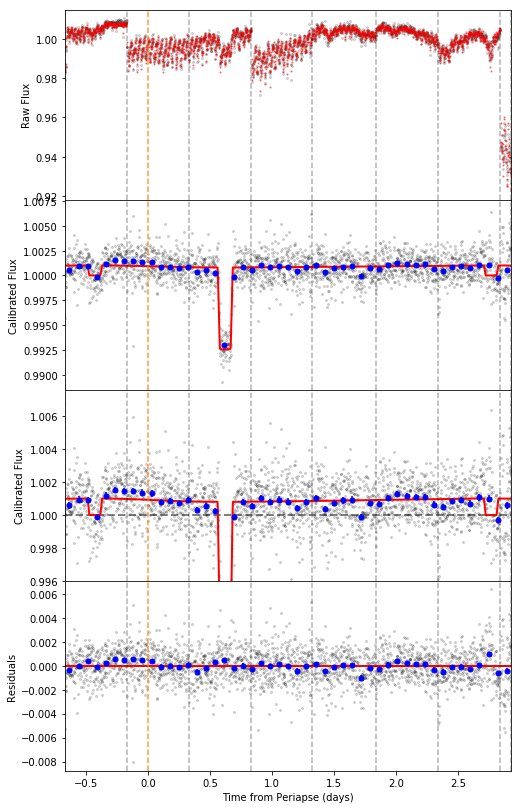

In [30]:
if user =='Lisa':
    make_plots_custom.plot_bestfit(x, flux, mcmc_lightcurve, mcmc_detec, 
                            mode, xbreaks, savepath, peritime=0, nbin=bestfitNbin)
else:
    make_plots.plot_bestfit(x, flux, mcmc_lightcurve, mcmc_detec, mode, orb_breaks, savepath, nbin=bestfitNbin)#, fontsize=18)

Over Ingress (18.7 min):
Expected Noise (ppm)	Observed Noise (ppm)
2714.233197113401	572.951338917601
Observed/Expected
0.21109141967865447

Over Transit/Eclipse (206.4 min):
Expected Noise (ppm)	Observed Noise (ppm)
818.3721007592635	269.1433883383054
Observed/Expected
0.3288765441644472


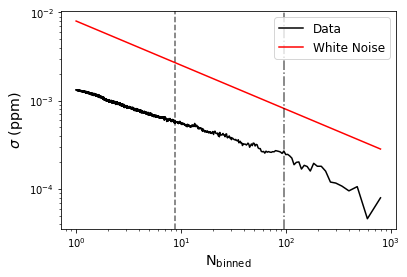

In [31]:
# if McCubes is installed
if 'timeavg' in sys.modules:
    intTime = (time[1]-time[0])
    minBins = 5
    residuals = flux/mcmc_detec - mcmc_lightcurve

    #WARNING: these durations assume circular orbits!!!
    ingrDuration = helpers.getIngressDuration(p0_mcmc, p0_labels, p0_obj, intTime)
    occDuration = helpers.getOccultationDuration(p0_mcmc, p0_labels, p0_obj, intTime)

    make_plots.plot_rednoise(residuals, minBins, ingrDuration, occDuration, intTime, mode, savepath, savetxt=True)

else:
    #Noise vs bin-size to look for red noise
    residuals = flux/mcmc_detec - mcmc_lightcurve

    sigmas = []
    for i in range(3,len(residuals)):
        sigmas.append(helpers.binnedNoise(x,residuals,i))
    sigmas = np.array(sigmas)

    n_binned = len(residuals)/np.arange(3,len(residuals))

    #In case there is a NaN or something while binning
    n_binned = n_binned[np.where(np.isfinite(sigmas))[0]]
    sigmas = sigmas[np.where(np.isfinite(sigmas))[0]]
    
    
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')

    if 'sigF' in p0_labels:
        sigFMCMC = p0_mcmc[np.where(p0_labels == 'sigF')[0][0]]
    else:
        sigFMCMC = p0_obj.sigF
    if 'rp' in p0_labels:
        rpMCMC = p0_mcmc[np.where(p0_labels == 'rp')[0][0]]
    else:
        rpMCMC = p0_obj.rp
    if 'a' in p0_labels:
        aMCMC = p0_mcmc[np.where(p0_labels == 'a')[0][0]]
    else:
        aMCMC = p0_obj.a
    if 'per' in p0_labels:
        perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
    else:
        perMCMC = p0_obj.per

    #WARNING: these durations assume circular orbits!!!
    eclDuration = (2*rpMCMC/(2*np.pi*aMCMC/perMCMC))/((time[1]-time[0])) #Eclipse/transit ingress time
    trDuration = (2/(2*np.pi*aMCMC/perMCMC))/((time[1]-time[0])) #Transit/eclipse duration

    ax.plot(n_binned, sigmas, c='black', label='Data')
    ax.plot([n_binned[-1],n_binned[0]], [sigFMCMC, sigFMCMC/np.sqrt(n_binned[0])], c='red', label='White Noise')
    ylim = ax.get_ylim()
    plt.plot([eclDuration,eclDuration],ylim, color='black', ls='--', alpha=0.6)
    plt.plot([trDuration,trDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    plt.ylabel(r'$\sigma$ (ppm)', fontsize='x-large')
    plt.xlabel(r'N$_{\rm binned}$', fontsize='x-large')
    plt.legend(loc='best', fontsize='large')
    plotname = savepath + 'MCMC_'+mode+'_RedNoise.pdf'
    plt.savefig(plotname, bbox_inches='tight')


    #Figure out how much red noise we have

    #Eclipse Duration
    sreal = sigmas[np.where(n_binned<=eclDuration)[0][0]]*1e6
    s0 = sigFMCMC/np.sqrt(n_binned[np.where(n_binned<=eclDuration)[0][0]])*1e6
    outStr = 'Over Ingress ('+str(round(eclDuration*((time[1]-time[0]))*24*60, 1))+' min):\n'
    outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
    outStr += str(s0)+'\t'+str(sreal)+'\n'
    outStr += 'Observed/Expected\n'
    outStr += str(sreal/s0)+'\n\n'
    #Transit Duration
    sreal = sigmas[np.where(n_binned<=trDuration)[0][0]]*1e6
    s0 = sigFMCMC/np.sqrt(n_binned[np.where(n_binned<=trDuration)[0][0]])*1e6
    outStr += 'Over Transit/Eclipse ('+str(round(trDuration*((time[1]-time[0]))*24*60, 1))+' min):\n'
    outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
    outStr += str(s0)+'\t'+str(sreal)+'\n'
    outStr += 'Observed/Expected\n'
    outStr += str(sreal/s0)

    print(outStr)
with open(plotname[:-3]+'txt','w') as file:
    file.write(outStr)

# Is $\chi ^2$ improving?

In [43]:
#Binned data
data = flux/mcmc_detec
astro  = mcmc_lightcurve
if 'sigF' in p0_labels:
    sigFMCMC = p0_mcmc[np.where(p0_labels == 'sigF')[0][0]]
else:
    sigFMCMC = p0_obj.sigF
if 'bliss' in mode.lower():
    nKnotsUsed = len(signal_inputs[-4][signal_inputs[-2]])
    ndim_eff = ndim+nKnotsUsed
else:
    ndim_eff = ndim
chisB = helpers.chi2(data, astro, sigFMCMC)
logLB = helpers.loglikelihood(data, astro, sigFMCMC)
EB = helpers.evidence(logLB, ndim, len(data))
BICB = -2*EB


#Unbinned data
'''Get model'''
astro_full   = astrofunc(time_full, *p0_mcmc[:ind_a])
if 'bliss' in mode.lower():
    signal_inputs_full = bliss.precompute(flux_full, time_full, xdata_full, ydata_full,
                                          psfxw_full, psfyw_full, mode,
                                          astro_full, blissNBin, savepath, False)
elif 'pld' in mode.lower():
    signal_inputs_full = (flux_full, time_full, Pnorm_full, mode)
    detec_inputs  = (Pnorm, mode)
elif 'poly' in mode.lower():# and 'psfw' in mode.lower():
    signal_inputs_full = (flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full, mode)

signal_full = signalfunc(signal_inputs_full, *p0_mcmc)
detec_full = signal_full/astro_full
data_full = flux_full/detec_full

'''Get Fitted Uncertainty'''
ferr_full = sigFMCMC*np.sqrt(nFrames)

N = len(data_full)
if 'bliss' in mode.lower():
    nKnotsUsed_full = len(signal_inputs_full[-4][signal_inputs_full[-2]])
    ndim_eff_full = ndim+nKnotsUsed_full
else:
    ndim_eff_full = ndim

chis = helpers.chi2(data_full, astro_full, ferr_full)
logL = helpers.loglikelihood(data_full, astro_full, ferr_full)
E = helpers.evidence(logL, ndim_eff_full, N)
BIC = -2*E

out = """Binned data:
chi2 = {0}
chi2datum = {1}
Likelihood = {2}
Evidence = {3}
BIC = {4}

Unbinned data:
chi2 = {5}
chi2datum = {6}
Likelihood = {7}
Evidence = {8}
BIC = {9}""".format(chisB, chisB/len(flux), logLB, EB, BICB, chis, chis/len(xdata_full), logL, E, BIC) 
with open(savepath+'EVIDENCE_'+mode+'.txt','w') as file:
    file.write(out)
print(out)

Binned data:
chi2 = 18930.62745029495
chi2datum = 7.927398429771754
Likelihood = 5608.8570390384875
Evidence = 5538.853135767875
BIC = -11077.70627153575

Unbinned data:
chi2 = 96554.51111495425
chi2datum = 0.6452065240325979
Likelihood = 585190.7441941499
Evidence = 585083.4997636708
BIC = -1170166.9995273417


In [44]:
ResultMCMC_Params = Table()

for i in range(len(p0_labels)):
    ResultMCMC_Params[p0_labels[i]] = MCMC_Results[i]

ResultMCMC_Params['offset'] = offset
ResultMCMC_Params['tDay'] = [np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16)]
ResultMCMC_Params['tNight'] = [np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)]
    
ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['chi2datum'] = [chisB/len(flux)]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = savepath + 'ResultMCMC_'+mode+'_Params.npy'
np.save(pathres, ResultMCMC_Params)

NameError: name 'tday' is not defined

In [45]:
# determining in-eclipse and in-transit index

# generating transit model

if 't0' in p0_labels:
    t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
else:
    t0MCMC = p0_obj.t0
if 'per' in p0_labels:
    perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
else:
    perMCMC = p0_obj.per
if 'rp' in p0_labels:
    rpMCMC = p0_mcmc[np.where(p0_labels == 'rp')[0][0]]
else:
    rpMCMC = p0_obj.rp
if 'a' in p0_labels:
    aMCMC = p0_mcmc[np.where(p0_labels == 'a')[0][0]]
else:
    aMCMC = p0_obj.a
if 'inc' in p0_labels:
    incMCMC = p0_mcmc[np.where(p0_labels == 'inc')[0][0]]
else:
    incMCMC = p0_obj.inc
if 'ecosw' in p0_labels:
    ecoswMCMC = p0_mcmc[np.where(p0_labels == 'ecosw')[0][0]]
else:
    ecoswMCMC = p0_obj.ecosw
if 'esinw' in p0_labels:
    esinwMCMC = p0_mcmc[np.where(p0_labels == 'esinw')[0][0]]
else:
    esinwMCMC = p0_obj.esinw
if 'q1' in p0_labels:
    q1MCMC = p0_mcmc[np.where(p0_labels == 'q1')[0][0]]
else:
    q1MCMC = p0_obj.q1
if 'q2' in p0_labels:
    q2MCMC = p0_mcmc[np.where(p0_labels == 'q2')[0][0]]
else:
    q2MCMC = p0_obj.q2
if 'fp'in p0_labels:
    fpMCMC = p0_mcmc[np.where(p0_labels == 'fp')[0][0]]
else:
    fpMCMC = p0_obj.fp

eccMCMC = np.sqrt(ecoswMCMC**2 + esinwMCMC**2)
wMCMC   = np.arctan2(esinwMCMC, ecoswMCMC)
u1MCMC  = 2*np.sqrt(q1MCMC)*q2MCMC
u2MCMC  = np.sqrt(q1MCMC)*(1-2*q2MCMC)

trans, t_sec, true_anom = astro_models.transit_model(time, t0MCMC, perMCMC, rpMCMC,
                                                     aMCMC, incMCMC, eccMCMC, wMCMC,
                                                     u1MCMC, u2MCMC)
# generating secondary eclipses model
eclip = astro_models.eclipse(time, t0MCMC, perMCMC, rpMCMC, aMCMC, incMCMC, eccMCMC, wMCMC,
                             fpMCMC, t_sec)

# get in-transit indices
ind_trans  = np.where(trans!=1)
# get in-eclipse indices
ind_eclip  = np.where((eclip!=(1+fpMCMC)))
# seperating first and second eclipse
ind_ecli1 = ind_eclip[0][np.where(ind_eclip[0]<int(len(time)/2))]
ind_ecli2 = ind_eclip[0][np.where(ind_eclip[0]>int(len(time)/2))]

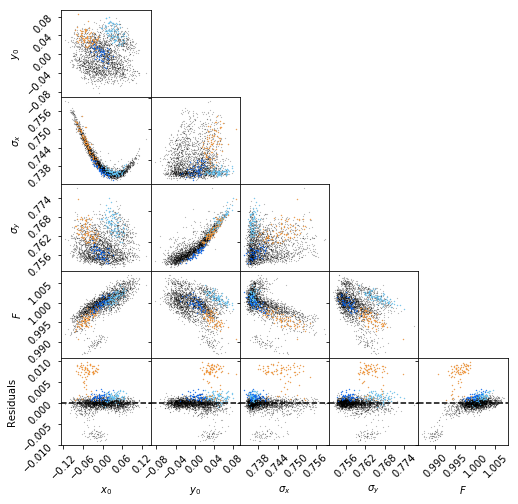

In [46]:
residual = flux/mcmc_detec - mcmc_lightcurve

data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecli1], ydata[ind_ecli1], psfxw[ind_ecli1], psfyw[ind_ecli1], flux[ind_ecli1], residual[ind_ecli1]]
data3 = [xdata[ind_trans], ydata[ind_trans], psfxw[ind_trans], psfyw[ind_trans], flux[ind_trans], residual[ind_trans]]
data4 = [xdata[ind_ecli2], ydata[ind_ecli2], psfxw[ind_ecli2], psfyw[ind_ecli2], flux[ind_ecli2], residual[ind_ecli2]]
label = [r'$x_0$', r'$y_0$', r'$\sigma _x$', r'$\sigma _y$', r'$F$', r'Residuals']

plotname = savepath + 'MCMC_'+mode+'_7.pdf'
helpers.triangle_colors(data1, data2, data3, data4, label, plotname)